# Disaggregated population estimates: Neural networks approach
This notebook demonstrates a machine learning approach for disaggregated population estimates, employing convolutional neural networks (CNN):
* [Convolutional neural networks for disaggregated population mapping using open data](https://hal.inria.fr/hal-01852585)

### Requirements
* INSEE population count data, please refer to the notebook [6-Disaggregated-population-estimates-Pre-requisites](https://github.com/lgervasoni/urbansprawl/tree/master/examples/6-Disaggregated-population-estimates-Pre-requisites.ipynb)

### Approach
* End-to-end framework for computing disaggregated population mapping using convolutional neural networks (CNNs).
* Using urban data extracted from the OpenStreetMap database, a set of urban features are generated which are used to perform population density estimates at a higher resolution.
* Carried out for French cities, where fine-grained population count data exist, hence enabling a validation procedure.

In [1]:
# snippet for relative imports
import os, sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path: sys.path.append(module_path)

import matplotlib.pyplot as plt
import osmnx as ox
import urbansprawl as us

ox.config(log_file=True, log_console=True, log_name='disaggregated_population_cnn', log_filename='disaggregated_population_cnn', use_cache=True)
figsize = (12,8)

from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Flatten, Conv1D

import tensorflow
tensorflow.__version__

Using TensorFlow backend.


'1.10.0'

### Population count data
* Resolution: 200m x 200m
* INSEE population count data, please refer to the pre-requisites notebook [6-Disaggregated-population-estimates-Pre-requisites](https://github.com/lgervasoni/urbansprawl/tree/master/examples/6-Disaggregated-population-estimates-Pre-requisites.ipynb)

In [2]:
# Set the path to the INSEE population count data shapefiles
file_insee_shapefile = "./population_data/insee/carr_pop4326.shp"
file_insee_population_count = "./population_data/insee/car_m.dbf"

assert os.path.isfile(file_insee_shapefile), "Verify pre-requisites: https://github.com/lgervasoni/urbansprawl/tree/master/examples/6-Disaggregated-population-estimates-Pre-requisites.ipynb"
assert os.path.isfile(file_insee_population_count),  "Verify pre-requisites: https://github.com/lgervasoni/urbansprawl/tree/master/examples/6-Disaggregated-population-estimates-Pre-requisites.ipynb"

### Objective
* The goal is to perform disaggregated population estimates from coarse to fine grained gridded population count data
    * Grid-cells of 1km x 1km are disaggregated into 25 times finer grid-cells of 200m x 200m
    * Population count data for coarse and fine grained resolutions are provided in the notebook [6-Disaggregated-population-estimates-Pre-requisites](https://github.com/lgervasoni/urbansprawl/tree/master/examples/6-Disaggregated-population-estimates-Pre-requisites.ipynb)

### Cities to analyze
* Utilization of INSEE data (French cities)
    * Provides a fine grained population count data needed to create ground-truth samples
    * A Convolutional Neural Networks (CNN) model is trained and validated using the generated ground-truth data
* French cities with more than 150,000 inhabitants: 
    * https://en.wikipedia.org/wiki/List_of_the_75_largest_cities_in_France_(2012_census)


In [3]:
# Cities
cities_french = [ "Paris", "Marseille", "Lyon", "Toulouse", "Nice", "Nantes", "Strasbourg", 
                 "Montpellier", "Bordeaux", "Rennes", "Reims", "Saint-Étienne", "Toulon", 
                 "Grenoble", "Dijon"] 
regions_args = []

# Paris
north, west, south, east = 48.923994, 2.234681, 48.792475, 2.477216
regions_args.append( {"east":east, "north":north, "south":south, "west":west} )
# Marseille
regions_args.append( {"place":"Marseille, France", "which_result":2} )
# Lyon
east, north, south, west = 4.988479, 45.8421941, 45.6606074, 4.725495
regions_args.append( {"east":east, "north":north, "south":south, "west":west} )
# Toulouse
north, west, south, east = 43.669756, 1.344949, 43.536251, 1.518327
regions_args.append( {"east":east, "north":north, "south":south, "west":west} )
# Nice
regions_args.append( {"place":"Nice, France"} )
# Nantes
north, west, south, east = 47.294599, -1.657047, 47.147503, -1.423848
regions_args.append( {"east":east, "north":north, "south":south, "west":west} )
# Strasbourg
north, west, south, east = 48.637827, 7.663381, 48.500269, 7.812597
regions_args.append( {"east":east, "north":north, "south":south, "west":west} )
# Montpellier
north, west, south, east = 43.661329, 3.791819, 43.558116, 3.987571
regions_args.append( {"east":east, "north":north, "south":south, "west":west} )
# Bordeaux
north, west, south, east = 44.919291, -0.686995, 44.773591, -0.479508
regions_args.append( {"east":east, "north":north, "south":south, "west":west} )
# Rennes
north, west, south, east = 48.152259, -1.751516, 48.060092, -1.567830
regions_args.append( {"east":east, "north":north, "south":south, "west":west} )
# Reims
north, west, south, east = 49.318056, 3.922752, 49.186250, 4.135484
regions_args.append( {"east":east, "north":north, "south":south, "west":west} )
# Saint-Étienne
north, west, south, east = 45.480850, 4.243652, 45.378521, 4.488078
regions_args.append( {"east":east, "north":north, "south":south, "west":west} )
# Toulon
north, west, south, east = 43.177904, 5.730857, 43.032650, 6.077037
regions_args.append( {"east":east, "north":north, "south":south, "west":west} )
# Grenoble
north, west, south, east = 45.277655, 5.604533, 45.078518, 5.956952
regions_args.append( {"east":east, "north":north, "south":south, "west":west} )
# Dijon
north, west, south, east = 47.389002, 4.917615, 47.240359, 5.176653
regions_args.append( {"east":east, "north":north, "south":south, "west":west} )

### Process the data
* Get OSM data for each French city of interest
* Get the corresponding population count extract for input city shape
* Calculate the urban features for each grid-cell with population count data
* Generate the ground-truth data for each city, including population count data and urban features for each grid-cell
    * These data will be employed during the training and testing procedure of the proposed machine learning approach

In [4]:
import time
start_time = time.time()

### INSEE data: Only french cities
for city_ref, region_args in zip(cities_french, regions_args):
    print("----------")
    print(city_ref)
    
    print("Extract OSM data: ", region_args)
    # Process OSM data
    # %time df_osm_built, df_osm_building_parts, df_osm_pois = us.get_processed_osm_data(city_ref=city_ref, region_args=region_args)
    
    print("INSEE population extract")
    # Extract INSEE region of interest
    # %time df_insee = us.get_extract_population_data(city_ref=city_ref, data_source="insee", to_crs=df_osm_built.crs, pop_shapefile=file_insee_shapefile, pop_data_file=file_insee_population_count, polygons_gdf=df_osm_built)
    
    print("Urban features calculation")
    # Compute urban features
    # %time urban_features = us.compute_full_urban_features(city_ref=city_ref, df_osm_built=df_osm_built, df_osm_pois=df_osm_pois, df_insee=df_insee, data_source="insee")
    %time urban_features = us.compute_full_urban_features(city_ref=city_ref, data_source="insee")
    urban_features.drop('built_up_m2', axis=1, inplace=True)
    
    print("Ground truth computation using population count data and urban features")
    # Generate the Y (population densities) and X (normalised urban features) vectors in order to train an algorithm for population downscaling estimates
    %time Y_vec, X_vec, X_names = us.get_training_testing_data(city_ref, urban_features)

elapsed_time = int(time.time() - start_time)
print("Total Elapsed time (H:M:S): " + '{:02d}:{:02d}:{:02d}'.format(elapsed_time // 3600, (elapsed_time % 3600 // 60), elapsed_time % 60) )

----------
Paris
Extract OSM data:  {'east': 2.477216, 'north': 48.923994, 'south': 48.792475, 'west': 2.234681}
CPU times: user 4h 43min 57s, sys: 2min 10s, total: 4h 46min 7s
Wall time: 4h 47min 42s
INSEE population extract
CPU times: user 8min 32s, sys: 11.4 s, total: 8min 44s
Wall time: 8min 39s
Urban features calculation
CPU times: user 2h 4min 42s, sys: 36.7 s, total: 2h 5min 19s
Wall time: 2h 3min 10s
Ground truth computation using population count data and urban features
CPU times: user 1h 50min 39s, sys: 4.97 s, total: 1h 50min 44s
Wall time: 1h 50min 43s
----------
Marseille
Extract OSM data:  {'place': 'Marseille, France', 'which_result': 2}
CPU times: user 3h 36min 38s, sys: 1min 48s, total: 3h 38min 27s
Wall time: 3h 38min 29s
INSEE population extract
CPU times: user 8min 38s, sys: 10.1 s, total: 8min 48s
Wall time: 8min 43s
Urban features calculation
CPU times: user 8h 18min 6s, sys: 2min 8s, total: 8h 20min 14s
Wall time: 8h 9min 52s
Ground truth computation using popula

### Visualization
* Population count data extracted for several cities

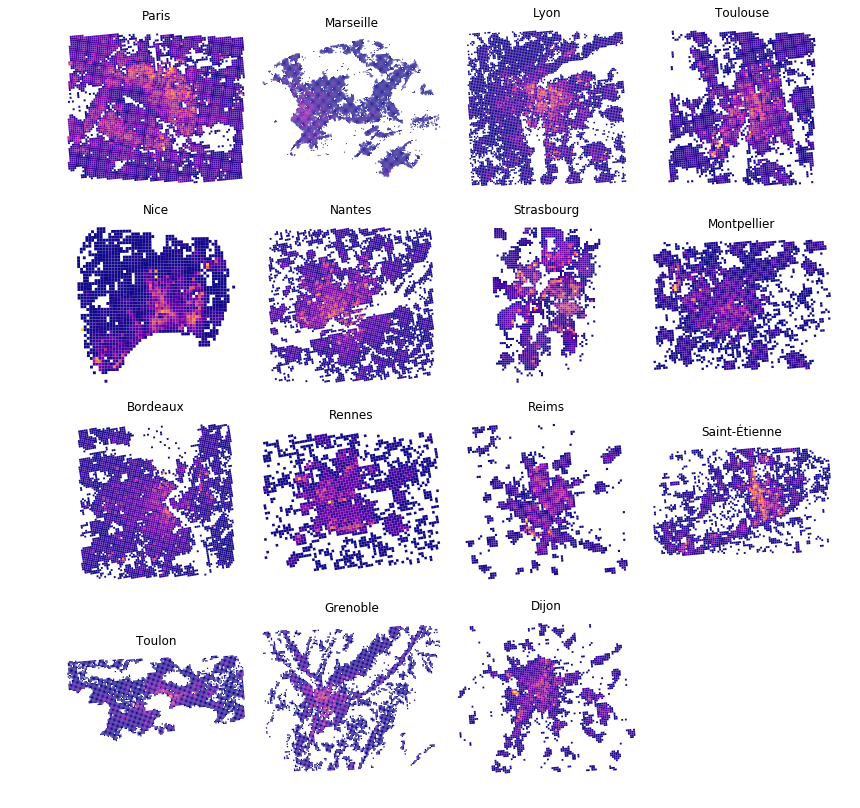

In [5]:
# Plots
f, axarr = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(14,14))
for ax_row in axarr:
    for ax in ax_row:
        ax.axis('off')

i, j = 0, 0
for city_ref in cities_french:
    # Plot population densities
    us.get_extract_population_data(city_ref=city_ref, data_source="insee").plot("pop_count", ax=axarr[i,j], cmap='plasma')
    # Title
    axarr[i,j].set_title(city_ref)
        
    j+=1
    if (j==4): j=0; i+=1

f.subplots_adjust(hspace=0.15, wspace=0)

### Visualization
* Urban features computed for the city of Paris

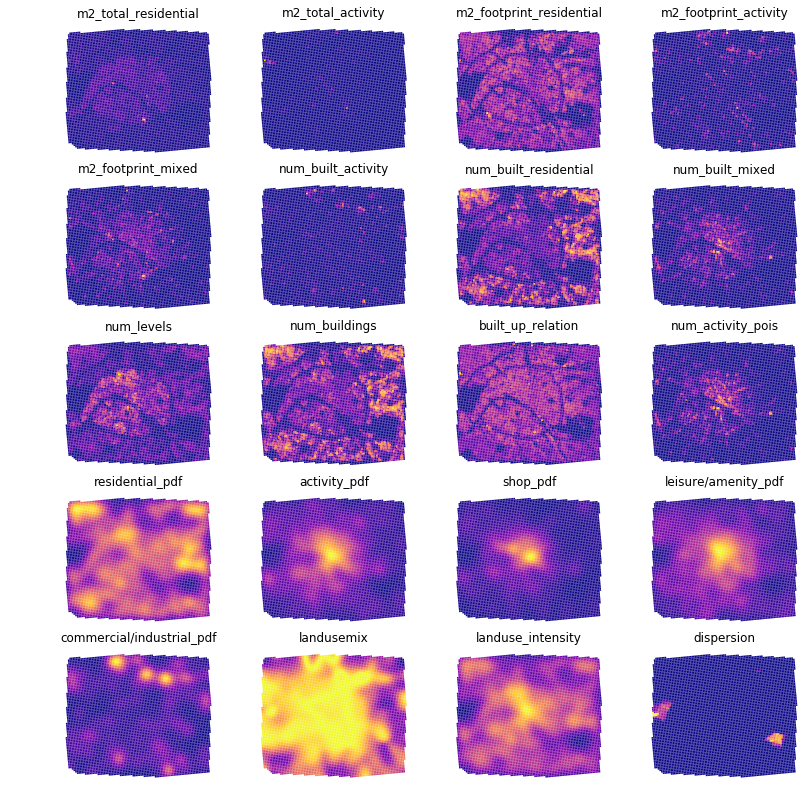

In [6]:
# Get urban features for an input city
urban_features = us.compute_full_urban_features(city_ref=cities_french[0], data_source="insee")

# Plots
f, axarr = plt.subplots(5, 4, sharex=True, sharey=True, figsize=(14,14))
for ax_row in axarr:
    for ax in ax_row:
        ax.axis('off')

i, j = 0, 0
for col in urban_features.columns:
    # Plot urban feature
    if (col in ['idINSPIRE', 'geometry', 'pop_count']): continue
    urban_features.plot(col, ax=axarr[i,j], cmap='plasma')
    # Title
    axarr[i,j].set_title(col)
    
    j+=1
    if (j==4): j=0; i+=1

f.subplots_adjust(hspace=0.15, wspace=0)

# Disaggrgated population estimates
* Machine learning approach using Convolutional Neural Networks (CNN)

## Population mapping

* Context: Available data
    * GPW data: resolution of 1km by 1km; world-wide coverage
    * INSEE data: resolution of 200m by 200m; limited coverage (France)
    * One grid-cell of GPW's resolution is equivalent to 25 squares of INSEE's resolution

* Goal: Perform population density estimates at a higher resolution than available population-count data
    * Distribute population densities from an input grid-cell (GPW resolution) into 25-finer squares (INSEE resolution)
    * Model: $f(X_{1}, X_{2}, ... , X_{N})$ $=$ $< Y_{1}, Y_{2}, ... , Y_{N} >$
        * $X_{i}$ : Set of urban features associated to grid-cell $i$
        * $Y_{i}$ : Estimated population density associated to grid-cell $i$
        * Subject to:
            * $\sum_{i=1}^{N} Y_{i} = 1$ 
            * $0 <= Y_{i} <= 1$    
    * grid-cell $i$ estimated population: $Y_{i}$ * P
        * P : Population count available (coarse-grained resolution)

* Training and validation:
    * Usage of INSEE's data as ground-truth, where 25-aggregated squares are equivalent to one GPW's square resolution


## Urban features

* Available urban features for each input grid-cell using INSEE resolution (population count data exist):
    * M² total residential usage
    * M² total activity usage
    * M² footprint residential usage
    * M² footprint activity usage
    * M² footprint mixed usage
    * Number of residential buildings
    * Number of activity buildings
    * Number of mixed buildings
    * Number of actvity POIs
    * Total number of building levels
    * Total number of buildings
    * Buildings built-up footprint relation [0%; 100%]
    * Sprawling indices: Dispersion
    * Sprawling indices: Land use mix
    * Densities estimation: Residential use
    * Densities estimation: Activity use
    * Densities estimation: Land use intensity (Residential + Activity)
    * Densities estimation: Commercial/industrial activity type use
    * Densities estimation: Shop activity type use
    * Densities estimation: Leisure/amenity activity type use

## Fully convolutional neural networks (CNNs)
* Input: Each sample consists of 25 aggregated grid-cells (N=25)
    * Urban features: $<X_{1}, X_{2}, ... , X_{N}>$
    * Ground-truth: $<Y_{1}, Y_{2}, ... , Y_{N}>$
        * $Y_{i}$: Population density associated to grid-cell $i$ (using INSEE population count)
* The employed architecture is fully convolutional
* Usage of Rectified Linear Units (ReLU) activation functions
* Output layer: Soft-max activation function
    * Associates population densities to each input grid-cell

### Stand-alone city validation
* The city of Lyon is kept for validation

In [7]:
city_sel = "Lyon"

# Validation data
Y_test, X_test, X_columns = us.get_Y_X_features_population_data(cities_selection=[city_sel])
# Shape
print( "Validation data shape:", Y_test.shape, X_test.shape )

# Training data
Y_train, X_train, X_columns = us.get_Y_X_features_population_data(cities_skip=[city_sel])
# Shape
print( "Training data shape:", Y_train.shape, X_train.shape )

Validation data shape: (10068, 25) (10068, 25, 20)
Training data shape: (86940, 25) (86940, 25, 20)


In [8]:
epochs = 100
batch_size = 32

_, input_shape_pixels, input_shape_features = X_train.shape
input_shape = (input_shape_pixels, input_shape_features)
"Input shape:", input_shape

('Input shape:', (25, 20))

In [9]:
model = Sequential()

# First layer: Input shape correspondent to X values
model.add(Conv1D(filters=10, kernel_size=1, strides=1, input_shape=input_shape  ) )
model.add(Activation('relu'))

model.add(Conv1D(filters=5, kernel_size=1, strides=1 ) )
model.add(Activation('relu'))

model.add(Conv1D(filters=1, kernel_size=1, strides=1 ) )
model.add(Activation('relu'))

# Flatten
model.add(Flatten())

# Force densities to sum 1
model.add(Activation('softmax'))

# Optimizer
optim = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

# Compile
model.compile(loss='mean_absolute_error', optimizer=optim, metrics=['mae'])

# Model shape
print( "Input:", model.input_shape, "Output:", model.output_shape )
model.summary()

Input: (None, 25, 20) Output: (None, 25)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_4 (Conv1D)            (None, 25, 10)            210       
_________________________________________________________________
activation_5 (Activation)    (None, 25, 10)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 25, 5)             55        
_________________________________________________________________
activation_6 (Activation)    (None, 25, 5)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 25, 1)             6         
_________________________________________________________________
activation_7 (Activation)    (None, 25, 1)             0         
_________________________________________________________________
flatten_2 (Flatten)          (None,

### Training
* Train the model excluding the city of Lyon, employed for the model's validation

In [10]:
# Fit
%time history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, Y_test))

Train on 86940 samples, validate on 10068 samples
Epoch 1/100
86940/86940 [==============================] - 9s 103us/step - loss: 0.0415 - mean_absolute_error: 0.0415 - val_loss: 0.0292 - val_mean_absolute_error: 0.0292
Epoch 2/100
86940/86940 [==============================] - 9s 101us/step - loss: 0.0282 - mean_absolute_error: 0.0282 - val_loss: 0.0267 - val_mean_absolute_error: 0.0267
Epoch 3/100
86940/86940 [==============================] - 9s 101us/step - loss: 0.0258 - mean_absolute_error: 0.0258 - val_loss: 0.0253 - val_mean_absolute_error: 0.0253
Epoch 4/100
86940/86940 [==============================] - 9s 100us/step - loss: 0.0241 - mean_absolute_error: 0.0241 - val_loss: 0.0237 - val_mean_absolute_error: 0.0237
Epoch 5/100
86940/86940 [==============================] - 9s 100us/step - loss: 0.0225 - mean_absolute_error: 0.0225 - val_loss: 0.0225 - val_mean_absolute_error: 0.0225
Epoch 6/100
86940/86940 [==============================] - 9s 98us/step - loss: 0.0213 - mean_a

Epoch 96/100
86940/86940 [==============================] - 9s 102us/step - loss: 0.0166 - mean_absolute_error: 0.0166 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189
Epoch 97/100
86940/86940 [==============================] - 9s 103us/step - loss: 0.0166 - mean_absolute_error: 0.0166 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189
Epoch 98/100
86940/86940 [==============================] - 9s 102us/step - loss: 0.0166 - mean_absolute_error: 0.0166 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189
Epoch 99/100
86940/86940 [==============================] - 9s 103us/step - loss: 0.0166 - mean_absolute_error: 0.0166 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189
Epoch 100/100
86940/86940 [==============================] - 9s 98us/step - loss: 0.0166 - mean_absolute_error: 0.0166 - val_loss: 0.0189 - val_mean_absolute_error: 0.0189
CPU times: user 20min 39s, sys: 2min 36s, total: 23min 16s
Wall time: 13min 18s


### Loss values during the training procedure

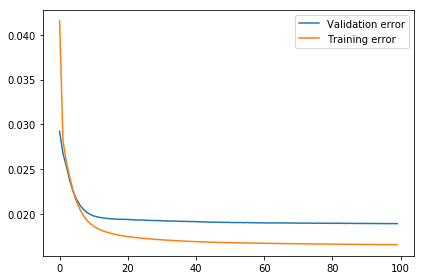

In [11]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
# Plot metrics
for k in history.history.keys():
    if ("mean_absolute_error" not in k): continue
    if ("val" in k): l = "Validation error"
    else: l = "Training error"
    ax.plot(history.history[k], label=l)

ax.xaxis.set_label("Iteration")
ax.yaxis.set_label("Mean absolute error")
ax.legend(loc='upper right')
fig.tight_layout()
fig.savefig("images/CNN_" + k + '.png', dpi=200, pad_inches=0)
plt.show()

### Error computation
* Mean absolute error
* Root mean squared error

In [12]:
import numpy as np
import pandas as pd
from math import sqrt
from sklearn.metrics import mean_squared_error

MAE = []
RMSE = []

for X_, Y_ in zip(X_test, Y_test): # Validation data
    # Predict and calculate the mean absolute error
    mae = model.evaluate(np.array([X_]), np.array([Y_]), verbose=0)[0]
    
    Y_pred = model.predict(np.array([X_]))[0]
    rmse = sqrt(mean_squared_error(Y_pred, Y_))

    MAE.append(mae)
    RMSE.append(rmse)
    
print( "Mean absolute error:", np.array(MAE).mean() )
print( "Root mean squared error:", np.array(RMSE).mean() )

Mean absolute error: 0.018897159828442152
Root mean squared error: 0.0355407370673855


* Mean absolute error

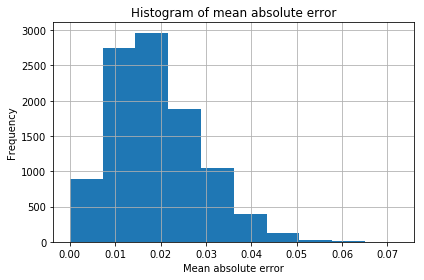

In [13]:
s_mae = pd.Series(np.array(MAE))
s_mae.hist()
plt.title("Histogram of mean absolute error")
plt.xlabel('Mean absolute error')
plt.ylabel('Frequency')
plt.tight_layout()

* Root mean squared error

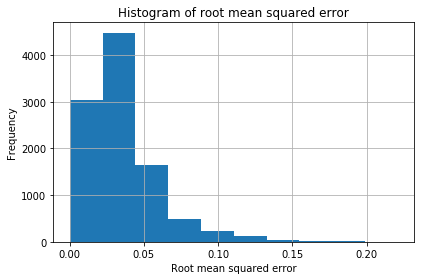

In [14]:
s_rmse = pd.Series(np.array(RMSE))
s_rmse.hist()
plt.title("Histogram of root mean squared error")
plt.xlabel('Root mean squared error')
plt.ylabel('Frequency')
plt.tight_layout()

## Leave-one-out cross-validation

In [15]:
def train_test_cnn(Y_test, X_test, Y_train, X_train, city_ref, leave_one_out_mae, leave_one_out_rmse):
    epochs = 100
    batch_size = 32

    _, input_shape_pixels, input_shape_features = X_train.shape
    input_shape = (input_shape_pixels, input_shape_features)
    "Input shape:", input_shape

    model = Sequential()

    # First layer: Input shape correspondent to X values
    model.add(Conv1D(filters=10, kernel_size=1, strides=1, input_shape=input_shape  ) )
    model.add(Activation('relu'))

    model.add(Conv1D(filters=5, kernel_size=1, strides=1 ) )
    model.add(Activation('relu'))

    model.add(Conv1D(filters=1, kernel_size=1, strides=1 ) )
    model.add(Activation('relu'))

    # Flatten
    model.add(Flatten())

    # Force densities to sum 1
    model.add(Activation('softmax'))

    # Optimizer
    optim = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)

    # Compile
    model.compile(loss='mean_absolute_error', optimizer=optim, metrics=['mae'])

    # Fit
    %time history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_data=(X_test, Y_test))
    
    # Evaluate model
    MAE, RMSE = [], []
    for X_, Y_ in zip(X_test, Y_test): # Validation data
        # Predict and calculate mean absolute error
        mae = model.evaluate(np.array([X_]), np.array([Y_]), verbose=0)[0]

        Y_pred = model.predict(np.array([X_]))[0]
        rmse = sqrt(mean_squared_error(Y_pred, Y_))

        MAE.append(mae)
        RMSE.append(rmse)
    
    # Associate errors to input city
    leave_one_out_mae[city_ref] = np.array(MAE).mean()
    leave_one_out_rmse[city_ref] = np.array(RMSE).mean()
        
    print( "MAE error: %.4f" % np.array(MAE).mean() )
    print( "RMSE error: %.4f" % np.array(RMSE).mean() )
    
leave_one_out_mae = {}
leave_one_out_rmse = {}

for city_selection in cities_french:
    print("************************")
    print(city_selection)
    
    # Validation data
    Y_test, X_test, X_columns = us.get_Y_X_features_population_data(cities_selection=[city_selection])
    # Training data
    Y_train, X_train, X_columns = us.get_Y_X_features_population_data(cities_skip=[city_selection])
    
    # Shape
    print( "Validation length:", Y_test.shape[0], "Training length:", Y_train.shape[0] )
    
    # Perform cross-validation for selected city
    %time train_test_cnn(Y_test, X_test, Y_train, X_train, city_selection, leave_one_out_mae, leave_one_out_rmse)

************************
Paris
Validation length: 7013 Training length: 89995
CPU times: user 27min 1s, sys: 4min 22s, total: 31min 23s
Wall time: 16min 24s
MAE error: 0.0314
RMSE error: 0.0443
CPU times: user 27min 28s, sys: 4min 25s, total: 31min 54s
Wall time: 16min 46s
************************
Marseille
Validation length: 14474 Training length: 82534
CPU times: user 25min 24s, sys: 4min 2s, total: 29min 26s
Wall time: 15min 34s
MAE error: 0.0171
RMSE error: 0.0348
CPU times: user 26min 19s, sys: 4min 7s, total: 30min 27s
Wall time: 16min 18s
************************
Lyon
Validation length: 10068 Training length: 86940
CPU times: user 26min 14s, sys: 4min 12s, total: 30min 27s
Wall time: 16min 10s
MAE error: 0.0183
RMSE error: 0.0343
CPU times: user 26min 54s, sys: 4min 16s, total: 31min 10s
Wall time: 16min 41s
************************
Toulouse
Validation length: 5300 Training length: 91708
CPU times: user 27min 52s, sys: 4min 32s, total: 32min 24s
Wall time: 17min 2s
MAE error: 0.

### Results
* Mean absolute error per-city
* Root mean squared error per-city
* Mean of mean absolute errors across cities
* Mean of root mean squared error across cities

* Mean absolute error

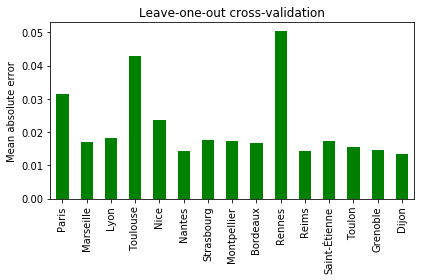

In [16]:
pd.Series(leave_one_out_mae).plot('bar', colormap="ocean")
plt.ylabel("Mean absolute error")
plt.title("Leave-one-out cross-validation")
plt.tight_layout()

In [17]:
print("Mean absolute error per city")
for city, mae in leave_one_out_mae.items():
    print(city, ": %.4f" % mae)

Mean absolute error per city
Paris : 0.0314
Marseille : 0.0171
Lyon : 0.0183
Toulouse : 0.0429
Nice : 0.0235
Nantes : 0.0143
Strasbourg : 0.0176
Montpellier : 0.0173
Bordeaux : 0.0168
Rennes : 0.0505
Reims : 0.0143
Saint-Étienne : 0.0174
Toulon : 0.0155
Grenoble : 0.0147
Dijon : 0.0134


* Root mean squared error

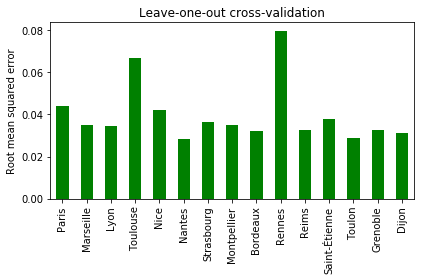

In [18]:
pd.Series(leave_one_out_rmse).plot('bar', colormap="ocean")
plt.ylabel("Root mean squared error")
plt.title("Leave-one-out cross-validation")
plt.tight_layout()

In [19]:
print("Root mean squared error per city")
for city, rmse in leave_one_out_rmse.items():
    print(city, ": %.4f" % rmse)

Root mean squared error per city
Paris : 0.0443
Marseille : 0.0348
Lyon : 0.0343
Toulouse : 0.0671
Nice : 0.0420
Nantes : 0.0285
Strasbourg : 0.0363
Montpellier : 0.0350
Bordeaux : 0.0321
Rennes : 0.0798
Reims : 0.0326
Saint-Étienne : 0.0379
Toulon : 0.0289
Grenoble : 0.0324
Dijon : 0.0311


* Mean of the different errors across cities
    * Mean absolute error
    * Root mean squared error

In [20]:
mean_absolute_error = np.array(list(leave_one_out_mae.values())).mean()
mean_rmsqe = np.array(list(leave_one_out_rmse.values())).mean()

print("Mean absolute error: %.4f" % mean_absolute_error)
print("Root mean squared error: %.4f" % mean_rmsqe)

Mean absolute error: 0.0217
Root mean squared error: 0.0398
